## Training: Fitness Function

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import os
os.chdir("..")
from sklearn.preprocessing import StandardScaler
from src.models.surrogate_model import *
from src.data.ff_dataloader import *
from src.preprocessing.transform_into_model_data_ff import *

#### Set seeds

In [5]:
# Set seeds in order to reproduce results
torch.manual_seed(73)
random.seed(73)
np.random.seed(73)

#### Load dataset

In [6]:
# Replace by true labeled dataset if available
train_dataset = DatasetFF(train=True, path="data/fitness_function")
test_dataset = DatasetFF(train=False, path="data/fitness_function")

In [7]:
train_dataset.X

tensor([[ 0.7136, -0.2095,  1.6897,  ..., -0.6123,  0.1137,  0.4600],
        [-0.7682, -0.8701,  1.0598,  ..., -1.7936,  2.8253,  0.7330],
        [ 0.1352, -0.1229,  0.5693,  ..., -0.7866,  2.4842,  1.3139],
        ...,
        [-1.6477,  0.2251, -1.4394,  ..., -0.0105, -1.1899, -0.0193],
        [ 0.7345, -1.0400,  0.2120,  ...,  0.8149, -0.7182,  1.0322],
        [-1.1228, -2.5455,  1.1063,  ...,  0.7117, -0.2163,  0.4367]])

In [8]:
train_dataset.y

tensor([[1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.]])

#### Scale training and test data

In [9]:
scaler = StandardScaler()

# only scale numeric variables that are not one-hot encoded
scaler.fit(train_dataset.X[:, 6:])
train_dataset.scale(scaler)
test_dataset.scale(scaler)

In [10]:
train_dataset.X

tensor([[ 0.7136, -0.2095,  1.6897,  ..., -0.6082,  0.1170,  0.4695],
        [-0.7682, -0.8701,  1.0598,  ..., -1.7828,  2.8180,  0.7479],
        [ 0.1352, -0.1229,  0.5693,  ..., -0.7815,  2.4782,  1.3405],
        ...,
        [-1.6477,  0.2251, -1.4394,  ..., -0.0098, -1.1815, -0.0196],
        [ 0.7345, -1.0400,  0.2120,  ...,  0.8109, -0.7117,  1.0531],
        [-1.1228, -2.5455,  1.1063,  ...,  0.7083, -0.2117,  0.4456]])

#### Build model and switch to GPU if available

In [11]:
fitness_function = FitnessFunction()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
fitness_function.to(device)

cpu


FitnessFunction(
  (hidden): ModuleList(
    (0): Linear(in_features=36, out_features=28, bias=True)
  )
  (out): Linear(in_features=28, out_features=4, bias=True)
)

In [12]:
fitness_function(test_dataset.X[0])

tensor([0.4357, 0.5010, 0.5098, 0.6045], grad_fn=<SigmoidBackward>)

#### Define loss function and optimizer

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(fitness_function.parameters())

#### Define Data loaders

In [14]:
# Useful because it automatically generates batches in the training loop and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

#### Model training

In [15]:
n_epochs = 100

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = []
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = fitness_function(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = fitness_function(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    if (it + 1) % 1 == 0:
        print(f'Epoch {it + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/100, Train Loss: 0.2426, Test Loss: 0.2291
Epoch 2/100, Train Loss: 0.2192, Test Loss: 0.2132
Epoch 3/100, Train Loss: 0.2075, Test Loss: 0.2055
Epoch 4/100, Train Loss: 0.2026, Test Loss: 0.2023
Epoch 5/100, Train Loss: 0.2003, Test Loss: 0.2011
Epoch 6/100, Train Loss: 0.1995, Test Loss: 0.2008
Epoch 7/100, Train Loss: 0.1974, Test Loss: 0.2006
Epoch 8/100, Train Loss: 0.1979, Test Loss: 0.2005
Epoch 9/100, Train Loss: 0.1960, Test Loss: 0.2005
Epoch 10/100, Train Loss: 0.1967, Test Loss: 0.2007
Epoch 11/100, Train Loss: 0.1949, Test Loss: 0.2006
Epoch 12/100, Train Loss: 0.1965, Test Loss: 0.2008
Epoch 13/100, Train Loss: 0.1957, Test Loss: 0.2009
Epoch 14/100, Train Loss: 0.1955, Test Loss: 0.2008
Epoch 15/100, Train Loss: 0.1952, Test Loss: 0.2010
Epoch 16/100, Train Loss: 0.1942, Test Loss: 0.2011
Epoch 17/100, Train Loss: 0.1954, Test Loss: 0.2012
Epoch 18/100, Train Loss: 0.1942, Test Loss: 0.2011
Epoch 19/100, Train Loss: 0.1957, Test Loss: 0.2013
Epoch 20/100, Train L

#### Plot the train loss and test loss per iteration

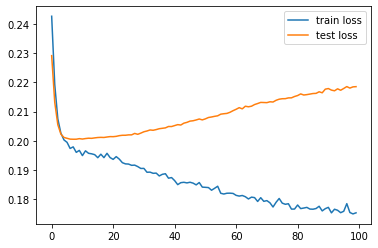

In [16]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

#### Save trained model

In [18]:
torch.save(fitness_function.state_dict(), "models/best_fitness_function_path.pth")

#### Load model and make predictions

In [20]:
model = FitnessFunction()
model.load_state_dict(torch.load("models/best_fitness_function_path.pth"))
model.eval()

FitnessFunction(
  (hidden): ModuleList(
    (0): Linear(in_features=36, out_features=28, bias=True)
  )
  (out): Linear(in_features=28, out_features=4, bias=True)
)

In [21]:
random_input = torch.from_numpy(np.random.normal(size=[1, 36]).astype(np.float32))

output = model(random_input)

In [22]:
output

tensor([[0.6638, 0.5108, 0.2818, 0.0953]], grad_fn=<SigmoidBackward>)

In [23]:
decode_classes(output)

array([[2]])